In [ ]:
import  time
from    tqdm.notebook           import  tqdm

import  numpy                   as      np
import  matplotlib.pyplot       as      plt
from    IPython                 import  display
from    ipywidgets              import  Output

import  find_library
try:
    from    .utils           import  *
    from    .distribution_v1 import  *
    from    .solvers_v1      import  *
except:
    from    numerical.utils              import  *
    from    numerical.distribution_v1    import  *
    from    numerical.solvers_v1         import  *
    

ModuleNotFoundError: No module named 'numerical_v1'

In [ ]:
# Time
DELTA_T:    float       = 5e-3
MIN_T:      float       = 0.0
MAX_T:      float       = 3.0
NUM_T:      int         = int(1 + (MAX_T - MIN_T + 0.1*DELTA_T) / DELTA_T)
ARR_T:      np.ndarray  = np.linspace(MIN_T, MAX_T, NUM_T)

# Velocity
DIMENSION:      int         = 2
RESOLUTION:     int         = 32
MAX_V:          float       = 3/LAMBDA
V:              np.ndarray  = velocity_grid(
                                    DIMENSION,
                                    RESOLUTION,
                                    MAX_V,
                                )
_V_EXTENT = [-MAX_V, MAX_V, MAX_V, -MAX_V]


# Further configurations - FFT
FFT_NORM:   str         = 'forward'
_FREQ:      np.ndarray  = fft_index(RESOLUTION)
FREQ_MIN:   int         = int(_FREQ.min())
FREQ_MAX:   int         = int(_FREQ.max())
freqs:      np.ndarray  = freq_tensor(DIMENSION, RESOLUTION)
    
# VHS model
VHS_ALPHA:      float   = 0
VHS_COEFF:      float   = 1/area_of_unit_sphere(DIMENSION)

# Metric
METRIC_ORDER:   float   = np.inf
def metric(pred: np.ndarray, target: np.ndarray) -> float:
    numer = np.linalg.norm((pred - target).flatten(), ord=METRIC_ORDER)
    denom = np.linalg.norm(target.flatten(), ord=METRIC_ORDER) + 1e-32
    return float(numer / denom)


# Problem type
PROBLEM_TYPE:   str = 'bkw'
PROBLEM_TYPE = PROBLEM_TYPE.lower()

## BKW solution
BKW_COEFF_EXT:  float = get_bkw_coeff_ext(DIMENSION)

## Maxwellian distribution
MAXWELLIAN_MEAN_DENSITY:        float       = np.ones((1,1))
MAXWELLIAN_MEAN_VELOCITY:       np.ndarray  = np.zeros((1,DIMENSION))
MAXWELLIAN_MEAN_TEMPERATURE:    float       = np.ones((1,1))

## Bimodal distribution
BIMODAL_MODE1_MEAN_DENSITY:     float       = 0.5
BIMODAL_MODE1_MEAN_VELOCITY:    np.ndarray  = np.array([MAX_V/6, *zeros(DIMENSION-1)])
BIMODAL_MODE1_MEAN_TEMPERATURE: float       = 0.5

In [ ]:
print(f"[ Initialization ]")
print(f"* Setting the initial value.")
arr_f:  np.ndarray
"""A space-homogeneous initial condition"""
if PROBLEM_TYPE == 'bkw':
    bkw_sol = bkw(
                    ARR_T, V,
                    coeff_ext   = BKW_COEFF_EXT,
                    vhs_coeff   = VHS_COEFF,
                    scale_v     = 1,
                    equation    = 'fpl',
                )
    arr_f = bkw_sol[[0]]
elif PROBLEM_TYPE == 'maxwellian':
    arr_f = maxwellian_homogeneous(
                V,
                MAXWELLIAN_MEAN_TEMPERATURE,
                MAXWELLIAN_MEAN_VELOCITY,
                MAXWELLIAN_MEAN_TEMPERATURE,
            )
elif PROBLEM_TYPE == 'bimodal':
    arr_f = maxwellian_homogeneous(
                V,
                BIMODAL_MODE1_MEAN_DENSITY,
                +BIMODAL_MODE1_MEAN_VELOCITY,
                BIMODAL_MODE1_MEAN_TEMPERATURE,
            ) + \
            maxwellian_homogeneous(
                V,
                BIMODAL_MODE1_MEAN_DENSITY,
                -BIMODAL_MODE1_MEAN_VELOCITY,
                BIMODAL_MODE1_MEAN_TEMPERATURE,
            )

print(f"* Computing the kernel components.")
sm_object = FastSM_FPL_VHS(
    dim         = DIMENSION,
    num_grid    = RESOLUTION,
    v_max       = MAX_V,
    vhs_coeff   = VHS_COEFF,
    vhs_alpha   = VHS_ALPHA,
    quad_order_uniform  = 150,
    quad_order_legendre = 150,
)
arr_f_fft = np.fft.fftn(arr_f, axes=sm_object.v_axes, norm=FFT_NORM)
print(f"\tDone.")

[ Initialization ]
* Setting the initial value.
----------[ BKW solution ]----------
* coeff_ext: 0.5
* coeff_int: 0.3183098861837907
------------------------------------
* Computing the kernel components.
	Done.


In [ ]:
print(f"[ Computation ]")
print(f"* Computing the numerical solution.")
arr_distribution        = []
arr_mean_density        = []
arr_mean_velocity       = []
arr_mean_temperature    = []
arr_rel_error           = []

out = Output()
display.display(out)

elapsed_time = time.time()

for cnt, t_curr in enumerate(tqdm(ARR_T)):
    # Backup the previous data and check if the terminal time has been reached
    arr_distribution.append(arr_f)
    
    rho, u, T = compute_moments_homogeneous(arr_f, V)
    arr_mean_density.append(rho)
    arr_mean_velocity.append(u)
    arr_mean_temperature.append(T)
    _target:    np.ndarray = None
    if PROBLEM_TYPE == 'bkw':
        _target = bkw_sol[[cnt]]
    elif PROBLEM_TYPE == 'maxwellian':
        _target = arr_distribution[0]
    elif PROBLEM_TYPE == 'bimodal' and _target is None:
        _target = maxwellian_homogeneous(
            V,
            arr_mean_density[0],
            arr_mean_velocity[0],
            arr_mean_temperature[0],
        )
    arr_rel_error.append( metric(arr_f, _target) )
    
    if cnt == NUM_T-1:
        break
    
    with out:
        _title = f"Relative error of order {METRIC_ORDER:.2f} by epoch {cnt} ($t={t_curr:.2f}$)\n"
        if PROBLEM_TYPE != 'bimodal':
            _title += f"Cumulative maximum error: {max(arr_rel_error):.4e}"
        else:
            _title += f"Cumulative minimum error: {min(arr_rel_error):.4e}"
        plt.suptitle(_title)
        plt.plot(ARR_T[:cnt+1], arr_rel_error, 'r-', linewidth=1)
        plt.xlim(MIN_T, MAX_T)
        plt.ylim(1e-12, 1e-0)
        plt.yscale('log')
        plt.grid(True)
        plt.show()
        display.clear_output(wait=True)
    
    # Update the function
    arr_f_fft = sm_object.forward(t_curr, arr_f_fft, DELTA_T, one_step_RK4_classic)
    arr_f = np.fft.ifftn(arr_f_fft, axes=sm_object.v_axes, norm=FFT_NORM).real

elapsed_time = time.time() - elapsed_time


arr_distribution        = np.stack(arr_distribution, axis=1)
arr_mean_density        = np.stack(arr_mean_density, axis=1)
arr_mean_velocity       = np.stack(arr_mean_velocity, axis=1)
arr_mean_temperature    = np.stack(arr_mean_temperature, axis=1)
arr_rel_error           = np.array(arr_rel_error)

print(f"\tDone. (Elapsed time: {elapsed_time:.2f} seconds)")

[ Computation ]
* Computing the numerical solution.


Output()

  0%|          | 0/601 [00:00<?, ?it/s]

	Done. (Elapsed time: 101.92 seconds)


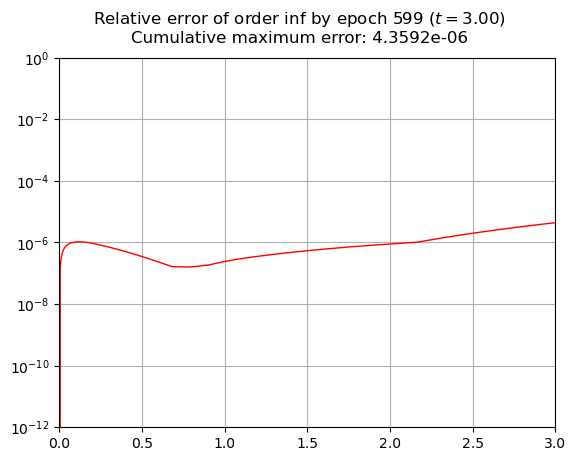

In [ ]:
plt.plot(ARR_T, arr_rel_error, 'r-', linewidth=1)
plt.suptitle(_title)
plt.xlim(MIN_T, MAX_T)
plt.ylim(1e-12, 1e-0)
plt.yscale('log')
plt.grid(True)
plt.show()

In [ ]:
np.savez(
    file = f"FPL_{DIMENSION}D__{PROBLEM_TYPE}_res{RESOLUTION}_L{MAX_V:.2e}_T{MAX_T}_dt{DELTA_T:.2e}",
    
    metric_order    = METRIC_ORDER,
    elapsed_time    = elapsed_time,
    
    min_t   = MIN_T,
    max_t   = MAX_T,
    delta_t = DELTA_T,
    
    dim     = DIMENSION,
    max_v   = MAX_V,
    res     = RESOLUTION,
    
    arr_distribution        = arr_distribution,
    arr_mean_density        = arr_mean_density,
    arr_mean_velocity       = arr_mean_velocity,
    arr_mean_temperature    = arr_mean_temperature,
    arr_rel_error           = arr_rel_error,
)

End of file